In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import t
from itertools import chain, combinations
from numba import njit, jit


#####__Col1_fileData được coi là Y, cột 2-->n thuộc Z, mô hình với Y và Z đã biết ta cần xác định ma trận tham số \Beta
###___và ma trận \sigma^2 (E(epsilon) = 0)


###_______________________Lấy dữ liệu từ file data________________###

data_frame = pd.read_excel("Data_Train_DONE.xlsx")
matrix_data = np.asarray(data_frame.astype(np.float64))
Y = matrix_data.T[0]

Z = np.zeros((len(matrix_data.T[0]), len(matrix_data.T)))
for i in range(len(Z)):
    Z[i][0] = 1

for row in range(len(Z)):
    for col in range(len(Z[0])-1):
        Z[row][col+1] = matrix_data[row][col+1]

print(Z)

[[ 1.00000e+00  3.00000e+00  1.50000e+00 ...  1.95500e+03  4.77658e+01
  -1.22339e+02]
 [ 1.00000e+00  5.00000e+00  2.50000e+00 ...  1.92100e+03  4.76345e+01
  -1.22367e+02]
 [ 1.00000e+00  3.00000e+00  2.00000e+00 ...  1.96600e+03  4.73672e+01
  -1.22151e+02]
 ...
 [ 1.00000e+00  4.00000e+00  1.50000e+00 ...  1.96300e+03  4.74612e+01
  -1.22069e+02]
 [ 1.00000e+00  3.00000e+00  3.00000e+00 ...  2.00000e+03  4.76956e+01
  -1.22392e+02]
 [ 1.00000e+00  3.00000e+00  2.50000e+00 ...  2.00800e+03  4.74472e+01
  -1.22207e+02]]


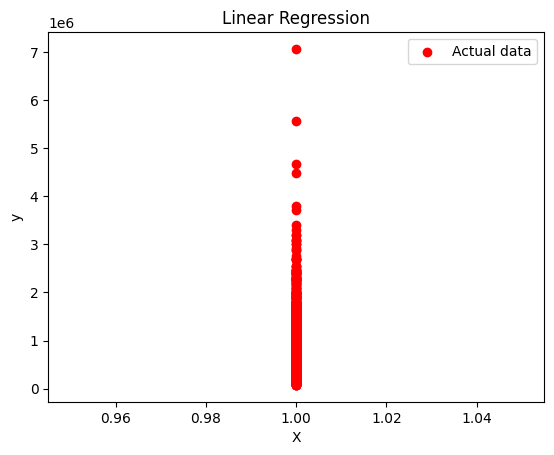

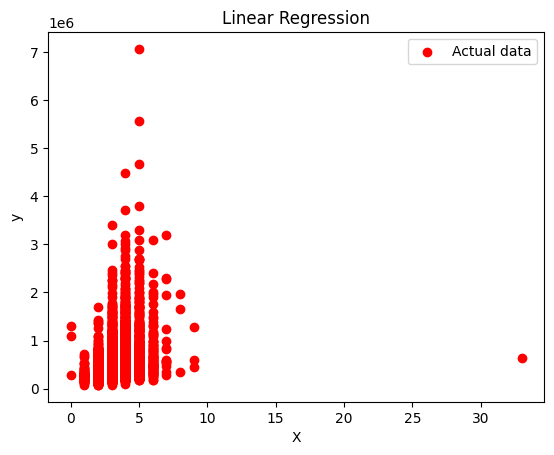

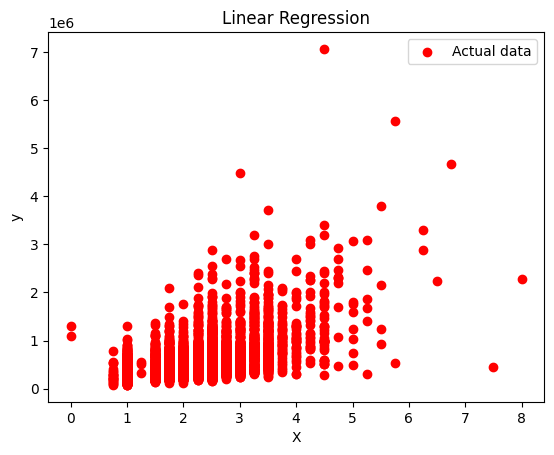

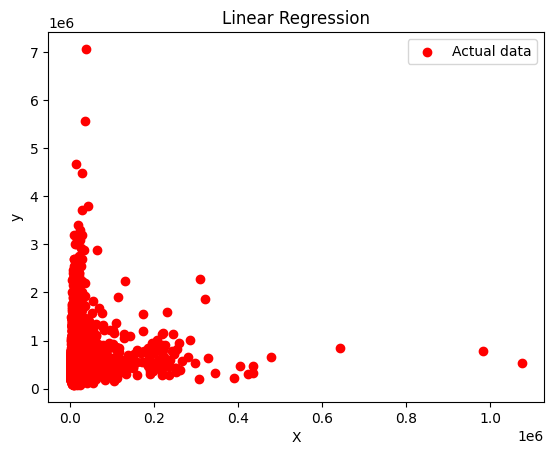

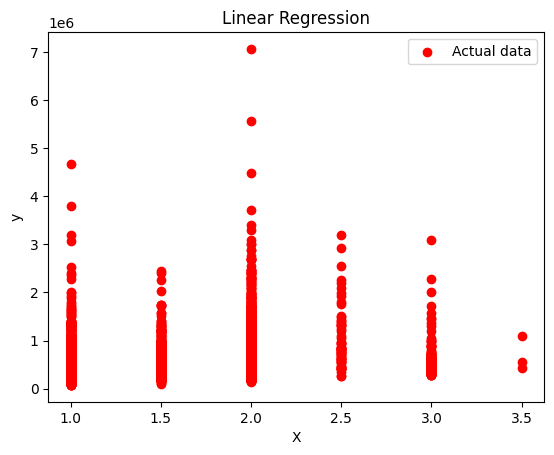

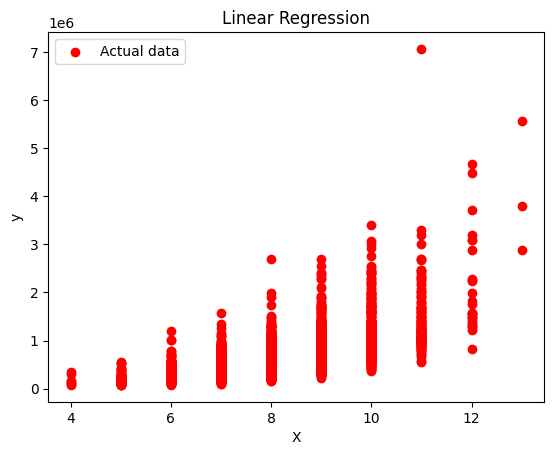

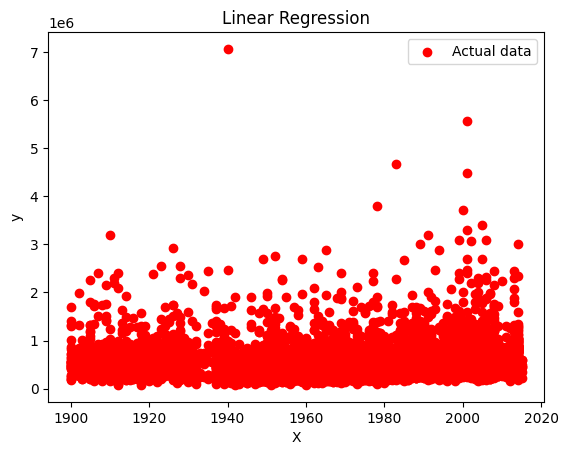

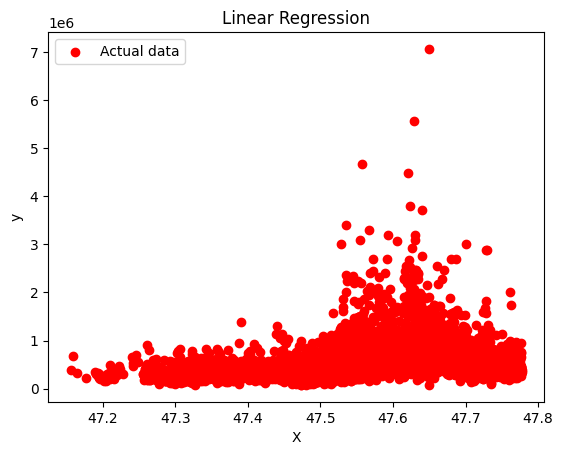

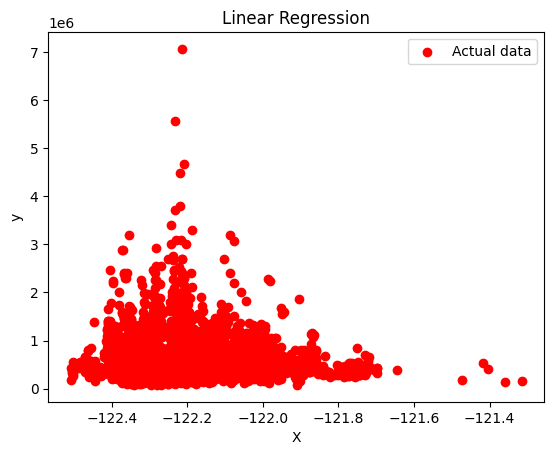

In [2]:
###_______________Vẽ các đồ thị kiểm tra sự phân bố giá trị của từng biến Z so với giá trị Y_____________###

def Graph(Y, Z):
    for idx in range(len(Z[0])):
        X = Z.T[idx].reshape(-1, 1)
        # Vẽ đồ thị
        plt.scatter(X, Y, color='red', label='Actual data')  # Dữ liệu thực tế
        # plt.plot(X, Y, color='red')  # Đường hồi quy
        plt.xlabel('X')
        plt.ylabel('y')
        plt.title('Linear Regression')
        plt.legend()
        plt.show()
Graph(Y, Z)

In [3]:
###___________________________Chuẩn hóa tập mẫu theo Z-score________________________###

def CHTM(Z):
    arr_u = np.zeros(len(Z[0])-1)
    arr_sigma = np.zeros(len(Z[0])-1)
    for k in range(1,len(Z[0])):
        u = sum(Z.T[k])/len(Z)
        sig = 0
        for leg in range(len(Z)):
            sig += (Z.T[k][leg] - u)**2
        sigma_BP = sig/len(Z)
        sigma = math.sqrt(sigma_BP)

        for ele in range(len(Z)):
            Z[ele][k] = (Z[ele][k]-u)/sigma
        arr_u[k-1] = u
        arr_sigma[k-1] = sigma
    return Z, arr_u, arr_sigma
Z, arr_u, arr_sigma = CHTM(Z)
print(Z)
print(arr_u)
print(arr_sigma)


[[ 1.         -0.41405976 -0.84359176 ... -0.5537304   1.49295989
  -0.89777274]
 [ 1.          1.65107621  0.4513246  ... -1.70439428  0.51680808
  -1.09426886]
 [ 1.         -0.41405976 -0.19613358 ... -0.18145679 -1.47043777
   0.42155837]
 ...
 [ 1.          0.61850822 -0.84359176 ... -0.28298596 -0.77159336
   0.9970113 ]
 [ 1.         -0.41405976  1.09878277 ...  0.96920709  0.97105694
  -1.26971183]
 [ 1.         -0.41405976  0.4513246  ...  1.23995153 -0.87567657
   0.02856613]]
[ 3.40100000e+00  2.15146429e+00  1.45433991e+04  1.51207143e+00
  7.72271429e+00  1.97136171e+03  4.75649853e+01 -1.22211071e+02]
[9.68459233e-01 7.72250652e-01 3.52297221e+04 5.38480662e-01
 1.17793939e+00 2.95481596e+01 1.34507766e-01 1.42496451e-01]


In [4]:
###____________________Ước lượng bình phương cực tiểu_______________###

def BPCT(Y, Z):
    Cum1 = (Z.T).dot(Z)
    Cum1 = np.linalg.inv(Cum1)      ##nghịch đảo
    Cum1_1 = Cum1.dot(Z.T)
    Beta_mu = Cum1_1.dot(Y)         # Ước lượng bình phương cực tiểu
    Y_mu =  Z.dot(Beta_mu)
    epsilon_mu = Y - Y_mu
    BPP_du = (epsilon_mu.T).dot(epsilon_mu)        ##Tổng bình phương phần dư
    return Beta_mu, Y_mu, epsilon_mu, BPP_du, Cum1

Beta_mu, Y_mu, epsilon_mu, BPP_du, Cum1 = BPCT(Y, Z)

# print("Beta mũ = ",Beta_mu)
# print("Y mũ = ",Y_mu)
# print("epsilon mũ = ", epsilon_mu)
# print("Tổng bình phương phần dư = ",BPP_du)
print("Bình phương phần dư = ", BPP_du)

###_______________________________________________________________###

Bình phương phần dư =  380997500854635.2


In [5]:
###___________________________Ước lượng tham số hồi quy______________________###

def ULTS(Y, Z, Beta_mu, Y_mu, epsilon_mu, BPP_du, Cum1):
    s1 = (epsilon_mu.T).dot(epsilon_mu)
    rankZ = np.linalg.matrix_rank(Z)
    s = math.sqrt(s1/(len(Z)-rankZ))        
    Arr_VarBj = np.zeros(rankZ)     ### Ma trận lưu độ lệch chuẩn ước lượng 
    for idx in range(len(Arr_VarBj)):
        Arr_VarBj[idx] = s*(math.sqrt(Cum1[idx][idx]))

    Y_ngang = sum(Y)/len(Y)


    ###___________Tính R^2___________###

    Tu_so = 0
    Mau_so = 0
    for i in range(len(Y)):
        Tu_so += (Y_mu[i] - Y_ngang)**2
    for j in range(len(Y)):
        Mau_so += (Y[j] - Y_ngang)**2
    R_BP = Tu_so/Mau_so         ###Tính R bình phương
    return Beta_mu, Arr_VarBj, R_BP, rankZ

Beta_mu, Arr_VarBj, R_BP, rankZ = ULTS(Y, Z, Beta_mu, Y_mu, epsilon_mu, BPP_du, Cum1)

# ###____________________________________###
# print("Hệ số ước lượng hồi quy: ", Beta_mu)
# print("Độ lệch chuẩn ước lượng: ", Arr_VarBj)
# ###_______________Nhận xét____________###
# if R_BP >= 0.8:
#     print("Dữ liệu thể hiện mối quan hệ hồi quy mạnh , R^2 = ", R_BP)
# else:
#     print("Dữ liệu thể hiện mối quan hệ hồi quy yếu , R^2 = ", R_BP)
# ###___________________________________###

# print("R^2 khi chưa loại bỏ Lerverage: ", R_BP)


In [6]:
###___________________________Độ đo Leverage//Check điểm outline____________________###
##______________Xét ma trận H = Z(Z.T Z)^{-1}Z.T

def Leverage_Func(Z):
    H = Z.dot(np.linalg.inv((Z.T).dot(Z))).dot(Z.T)
    # print(H)

    ###_______________Ngưỡng đánh giá high leverage trên thực tế tường là 2p/n hoặc 3p/n___

    check_high_lev = (3*(len(Z[0])-1))/len(Z)
    arr_check_point_high_lev = np.zeros(len(H))
    for i in range(len(H)):
        if H[i][i] > check_high_lev:
            arr_check_point_high_lev[i] = 1
    Point_high_lev = np.where(arr_check_point_high_lev == 1)[0]
    return Point_high_lev

Point_high_lev = Leverage_Func(Z)
print("Các điểm outline với ngưỡng đánh giá 3p/n = ",Point_high_lev)
print("Số điểm outline là: ",len(Point_high_lev))

Các điểm outline với ngưỡng đánh giá 3p/n =  [  82   97  101  114  130  179  254  255  266  286  299  306  348  359
  380  401  459  496  505  513  519  530  589  609  620  679  725  793
  797  851  938  939 1037 1085 1100 1133 1147 1173 1261 1290 1300 1313
 1319 1344 1348 1355 1359 1444 1480 1496 1498 1514 1575 1598 1637 1686
 1783 1835 1873 1906 1926 1958 2039 2074 2093 2141 2297 2301 2303 2345
 2432 2433 2454 2457 2484 2521 2523 2648 2668 2721 2771 2828 2898 2913
 3027 3044 3061 3080 3167 3168 3204 3239 3258 3302 3321 3327 3379 3396
 3419 3480 3542 3572 3595 3596 3630 3678 3701 3723 3732 3749 3762 3840
 3850 3851 3907 3908 3948 3967 3979 4023 4034 4124 4134 4176 4240 4249
 4267 4366 4420 4468 4490 4493 4520 4529 4532 4552 4571 4574 4607 4699
 4723 4726 4758 4804 4854 4910 4919 4973 5187 5215 5348 5391 5420 5425
 5434 5444 5463 5510 5573 5576 5909 5946 5972 5988 6017 6039 6114 6261
 6275 6340 6353 6361 6389 6413 6466 6598 6610 6614 6616 6665 6689 6697
 6715 6795 6908 6940 6960]
Số đi

In [7]:
###_______________Loại bỏ các điểm outline với ngưỡng đánh giá trên_____________###

def Remove_point(Y,Z):
    newY = np.delete(Y, Point_high_lev)
    newZ = np.delete(Z, Point_high_lev, axis= 0)
    return newY, newZ
###______________Kéo lại hàm để tính ước lượng bình phương cực tiểu và R^2
newY, newZ = Remove_point(Y,Z)

Beta_mu, Y_mu, epsilon_mu, BPP_du, Cum1 = BPCT(newY, newZ)
Beta_mu, Arr_VarBj, newR_BP, rankZ = ULTS(newY, newZ, Beta_mu, Y_mu, epsilon_mu, BPP_du, Cum1)

###____________________________________###
print("Hệ số ước lượng hồi quy: ", Beta_mu)
print("Độ lệch chuẩn ước lượng: ", Arr_VarBj)
###_______________Nhận xét____________###
# if newR_BP >= 0.8:
#     print("Dữ liệu thể hiện mối quan hệ hồi quy mạnh , R^2 = ", newR_BP)
# else:
#     print("Dữ liệu thể hiện mối quan hệ hồi quy yếu , R^2 = ", newR_BP)



Hệ số ước lượng hồi quy:  [ 548301.47126472    9541.30168672   92757.09935123   20576.00575253
    2438.02854392  215527.84565516 -115673.86326345   64386.84842327
   -4503.30057737]
Độ lệch chuẩn ước lượng:  [2747.02490925 3559.2000007  4501.88319244 7248.05102809 3385.2770652
 3884.95676687 3719.87659011 2799.94294073 3225.74700734]


In [8]:
###_____________Test____t-statistic_________________###

def Statistic(Y, Z, Beta_mu, Cum1):
    Y_j_BP = 0
    for ind in range(len(Y)):
        Y_j_BP += (Y[ind])**2
    Sigma_eps_BP = Y_j_BP - (Y.T).dot(Z).dot(Beta_mu)

    rankZ = np.linalg.matrix_rank(Z)
    Sigma_mu_BP = Sigma_eps_BP/(len(Z) - rankZ)

    ###______________Tính D(Beta_j_mu)______________###

    Arr_DBeta_mu = np.zeros(len(Beta_mu))
    MatrixDBeta = Sigma_mu_BP*Cum1
    for idx in range(len(Arr_DBeta_mu)):
        Arr_DBeta_mu[idx] = MatrixDBeta[idx][idx]
    # print(Arr_DBeta_mu)

    ###_______________Tính t-statistic____________###

    Arr_t_statisticZ = np.zeros(len(Beta_mu))
    for k in range(len(Arr_t_statisticZ)):
        Arr_t_statisticZ[k] = Beta_mu[k]/math.sqrt(Arr_DBeta_mu[k])
    # print("t-statistic tại Z: ", Arr_t_statisticZ)

    ###_______________Tính p-Value_______________###

    Arr_p_Value = np.zeros(len(Arr_t_statisticZ))
    for indx in range(len(Arr_p_Value)):
        Arr_p_Value[indx] = 2*(1-t.cdf(Arr_t_statisticZ[indx],7000))
    # print("p-Value: ", Arr_p_Value)


    ###__________________Bác bỏ giả thuyết H0: Beta_j = 0____________________###
    ###_____________Cọn mức tin cậy alpha = 5%_________________###

    GTH0 = np.zeros(len(Arr_p_Value))
    for id in range(len(GTH0)):
        if Arr_p_Value[id] < 0.05:
            GTH0[id] = 1
    return Arr_t_statisticZ, Arr_p_Value, GTH0

Arr_t_statisticZ, Arr_p_Value, GTH0 = Statistic(Y, Z, Beta_mu, Cum1)
print("t-statistic tại Z: ", Arr_t_statisticZ)
print("p-Value: ", Arr_p_Value)

Arr_t_statisticZ, Arr_p_Value, GTH0 = Statistic(newY, newZ, Beta_mu, Cum1)      ### khi đã loại bỏ điểm Leverage
print("Bác bỏ giả thuyết H0: ", GTH0)



t-statistic tại Z:  [183.56740215   2.46543742  18.94923513   2.6108299    0.66234356
  51.02181994 -28.59864497  21.14884893  -1.28392419]
p-Value:  [0.         0.01370842 0.         0.00905154 0.50777287 0.
 2.         0.         1.80078902]
Bác bỏ giả thuyết H0:  [1. 1. 1. 1. 0. 1. 0. 1. 0.]


In [9]:
###__________________________Kiểm tra tính đa cộng tuyến tính____________________###

##__________________Z_i_ngang_________________________________###

def n_Linear_Regression(Y, Z ):
    Arr_Zn = np.zeros(len(Z[0])-1)
    for idxx in range(len(Arr_Zn)):
        test1 = 0
        for idd in range(len(Z)):
            test1 += Z[idd][idxx+1]
        test1 = test1/len(Z)
        Arr_Zn[idxx] = test1
    # print(Arr_Zn)

    ##__________________Tính Z_i.Z_j ngang______________________###

    Arr_Z_ngang = np.zeros((len(Z[0])-1, len(Z[0])-1))
    # print(Arr_Z_ngang)

    for row in range(len(Arr_Z_ngang)):
        for col in range(len(Arr_Z_ngang)):
            Arr_Z_ngang[row][col] = (Arr_Zn[row])*(Arr_Zn[col])



    ###_______________________Tính S_ij__________________###

    Arr_s_ij = np.zeros((len(Z[0])-1, len(Z[0])-1))
    for rows in range(len(Arr_s_ij)):
        for cols in range(len(Arr_s_ij)):
            check1 = 0
            for ip in range(len(Z)):
                check1 += Z[ip][rows+1]*Z[ip][cols+1]
            check1 = check1/len(Z)
            Arr_s_ij[rows][cols] = (check1 - Arr_Z_ngang[rows][cols])


    ###______________________Tính r_ij______________________###

    Arr_Rij = np.zeros((len(Z[0])-1, len(Z[0])-1))          ## arr 2 chiều lưu các giá trị r_ij 
    for ro in range(len(Arr_Rij)):
        for co in range(len(Arr_Rij)):
            Arr_Rij[ro][co] = Arr_s_ij[ro][co]/math.sqrt((Arr_s_ij[ro][ro])*(Arr_s_ij[co][co]))

    for i in range(len(Arr_Rij)):
        for j in range(len(Arr_Rij)):
            if i >= j:
                Arr_Rij[i][j] = 0


    ###_________________________________Tính S00____________________###

    check2 = 0
    for id in range(len(Y)):
        check2 += (Y[id])**2
    check2 = check2/len(Y)
    s00 = check2 - (sum(Y)/len(Y))**2

    ###_________________Tính S0j___________________###

    Arr_S0J = np.zeros(len(Z[0])-1)
    for idx in range(len(Arr_S0J)):
        check3 = 0
        for idd in range(len(Y)):
            check3 += Y[idd]*Z[idd][idx+1]
        check3 = check3/len(Y)
        Arr_S0J[idx] = (check3 - (sum(Y)/len(Y))*(Arr_Zn[idx]))


    Arr_r0i = np.zeros(len(Z[0])-1)
    for i in range(len(Arr_r0i)):
        Arr_r0i[i] = Arr_S0J[i]/(math.sqrt(Arr_s_ij[i][i]*s00))
    return Arr_r0i, Arr_Rij

Arr_r0i, Arr_Rij = n_Linear_Regression(newY, newZ)

# print("S00 = ", s00)
print(Arr_Rij)
print(Arr_r0i)

[[ 0.          0.51878046  0.10303984  0.17367595  0.369931    0.17600599
  -0.01722507  0.17061022]
 [ 0.          0.          0.09947081  0.5106605   0.6676619   0.51426315
   0.0334257   0.25648996]
 [ 0.          0.          0.         -0.0596904   0.17491372  0.05343455
  -0.09432319  0.28160502]
 [ 0.          0.          0.          0.          0.46307404  0.49684799
   0.05411464  0.14528789]
 [ 0.          0.          0.          0.          0.          0.44368953
   0.11684297  0.2293256 ]
 [ 0.          0.          0.          0.          0.          0.
  -0.1452855   0.45128563]
 [ 0.          0.          0.          0.          0.          0.
   0.         -0.1160507 ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]]
[0.3220827  0.51196767 0.11873617 0.26454373 0.66679007 0.04349533
 0.31354426 0.03184803]


In [10]:
def TQPL(Arr_Rij):      ## tìm các cặp có hiện tượng đa cộng tuyến
    Arr_PL = []
    for idx in range(len(Arr_Rij)):
        place = np.where(Arr_Rij[idx] > 0.7)[0]
        if len(place) > 0:
            for i in range(len(place)):
                ps = np.zeros(2)
                ps[0] = idx+1
                ps[1] = place[i] + 1
                Arr_PL.append(ps)
    return Arr_PL
Arr_PL = TQPL(Arr_Rij)
print(Arr_PL)



[]


In [11]:
def all_subsets(s):
    return chain(*map(lambda x: combinations(s, x), range(0, len(s)+1)))

my_set = {1,2,3,4,5}
subsets = list(all_subsets(my_set))


print(subsets)
# for subset in subsets:
#     print(subset)


[(), (1,), (2,), (3,), (4,), (5,), (1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5), (1, 2, 3), (1, 2, 4), (1, 2, 5), (1, 3, 4), (1, 3, 5), (1, 4, 5), (2, 3, 4), (2, 3, 5), (2, 4, 5), (3, 4, 5), (1, 2, 3, 4), (1, 2, 3, 5), (1, 2, 4, 5), (1, 3, 4, 5), (2, 3, 4, 5), (1, 2, 3, 4, 5)]


In [12]:
###______________________________XÁC ĐỊNH BIẾN QUAN TRỌNG LÀM CHO R^2 MAX__________________### 
ARR_check_RBP = np.zeros(len(subsets))
index = -1
for subset in subsets:
    index += 1
    if len(subset) == len(my_set):
        ARR_check_RBP[-1] = 0
    if len(subset) < len(my_set):
        Arr_RBP = np.zeros(len(subset))
        for j in range(len(subset)):
            Arr_RBP[j] = subset[j]
        
        Z_new1 = np.delete(newZ, [int(x) for x in Arr_RBP], axis=1)
        Beta_mu, Y_mu, epsilon_mu, BPP_du, Cum1 = BPCT(newY, Z_new1)
        Arr_t_statisticZ, Arr_p_Value, GTH0 = Statistic(newY, Z_new1, Beta_mu, Cum1)
        Arr_r0i, Arr_Rij = n_Linear_Regression(newY, Z_new1)
        Beta_mu, Y_mu, epsilon_mu, BPP_du, Cum1 = BPCT(newY, Z_new1)
        Beta_mu, Arr_VarBj, newR_BP, rankZ = ULTS(newY, Z_new1, Beta_mu, Y_mu, epsilon_mu, BPP_du, Cum1)
        ARR_check_RBP[index] = newR_BP

print(ARR_check_RBP)    
choose_remove_var = np.where(ARR_check_RBP == np.max(ARR_check_RBP))[0][0]      ###Lấy ra vị trí cần loại bỏ Z_i
print(choose_remove_var)

[0.59307593 0.59264614 0.56768638 0.59259395 0.59304491 0.40900573
 0.55836564 0.59215719 0.59263104 0.40618972 0.56717175 0.56584782
 0.26716128 0.59258581 0.39882785 0.40305633 0.55780396 0.55639816
 0.18948414 0.59215595 0.39577524 0.40077788 0.56554573 0.24876033
 0.22119607 0.39426238 0.55606618 0.16459757 0.12766425 0.39171801
 0.20668167 0.        ]
0


In [13]:
#####_______________________Chọn mô hình và xử lý_____________________________#####

TP_choose1 = subsets[choose_remove_var]
choose1 = np.zeros(len(TP_choose1))
for i in range(len(TP_choose1)):
    choose1[i] = TP_choose1[i]

Z_LR = np.delete(newZ, [int(x) for x in choose1], axis=1)
Beta_mu, Y_mu, epsilon_mu, BPP_du, Cum1 = BPCT(newY, Z_LR)
Arr_t_statisticZ, Arr_p_Value, GTH0 = Statistic(newY, Z_LR, Beta_mu, Cum1)     ##Kiểm tra T-Statistic và p-value
Arr_r0i, Arr_Rij = n_Linear_Regression(newY, Z_LR)    
Beta_mu, Arr_VarBj, newR_BP, rankZ = ULTS(newY, Z_LR, Beta_mu, Y_mu, epsilon_mu, BPP_du, Cum1)  #Ước lượng tham số

###__________________________________________________###
###____________________________________###
print("Hệ số ước lượng hồi quy: ", Beta_mu)
print("Độ lệch chuẩn ước lượng: ", Arr_VarBj)
###_______________Nhận xét____________###
if newR_BP >= 0.8:
    print("Dữ liệu thể hiện mối quan hệ hồi quy mạnh , R^2 = ", newR_BP)
else:
    print("Dữ liệu thể hiện mối quan hệ hồi quy yếu , R^2 = ", newR_BP)

###_______________________________________________________________________________###
##Z_LR: Z đã chọn để hồi quy

Hệ số ước lượng hồi quy:  [ 548301.47126472    9541.30168672   92757.09935123   20576.00575253
    2438.02854392  215527.84565516 -115673.86326345   64386.84842327
   -4503.30057737]
Độ lệch chuẩn ước lượng:  [2747.02490925 3559.2000007  4501.88319244 7248.05102809 3385.2770652
 3884.95676687 3719.87659011 2799.94294073 3225.74700734]
Dữ liệu thể hiện mối quan hệ hồi quy yếu , R^2 =  0.5930759286535029


In [14]:
######____________________________Khảo sát phần dư của mô hình đã chọn___________________________#######
###______________________Giả thuyết H0: eps xấp xỉ phân phối chuẩn_______________###

###___________________Tìm trị riêng của ma trận I-H_____________________###

def TriRieng(Z):
    MAT_H = Z.dot(np.linalg.inv((Z.T).dot(Z))).dot(Z.T)
    MAT_I = np.zeros((len(MAT_H), len(MAT_H)))
    for i in range(len(MAT_I)):
        MAT_I[i][i] = 1
    IH = MAT_I - MAT_H
    eigenvalues, eigenvectors = np.linalg.eig(IH)
    eigenvalues = np.round(eigenvalues, decimals=2)
    TR0 = np.where(eigenvalues == 0)[0]
    TR1 = np.where(eigenvalues == 1)[0]
    L_TR0 = len(TR0)
    L_TR1 = len(TR1)
    return IH, L_TR0, L_TR1, eigenvalues, eigenvectors       ### L_TR0 = k + 1, LTR1 = n-k-1

IH, L_TR0, L_TR1, eigenvalues, eigenvectors = TriRieng(Z_LR)
print('Số trị riêng bằng 0 là: ',L_TR0)
print('Số trị riêng bằng 1 là: ',L_TR1)

Số trị riêng bằng 0 là:  9
Số trị riêng bằng 1 là:  6804


In [15]:
###_______________________Tính eps*______________________________###

###  P = eigenvectors1

eigenvalues1 = eigenvalues.real
eigenvectors1 = eigenvectors.real

epsilon_SAO = np.dot(np.linalg.inv(eigenvectors1), epsilon_mu)
print('eps_SAO = ',epsilon_SAO)
# print(epsilon_SAO)

###_________________________________________________________###

epsilon_SAO_ngang = sum(epsilon_SAO)/len(epsilon_SAO)
print('eps_SAO_ngang = ',epsilon_SAO_ngang)

check4 = 0
for k in range(len(epsilon_SAO)):
    check4 += epsilon_SAO[k]**2
# print(check4)
cum_2_2 = ((len(epsilon_SAO)**2)*(epsilon_SAO_ngang**2))/(len(epsilon_SAO) - L_TR0)
TSO1 = len(epsilon_SAO)*(math.sqrt((len(epsilon_SAO)-L_TR0-1)))*epsilon_SAO_ngang

TC_STUDENT = TSO1/((math.sqrt(len(epsilon_SAO)))*(math.sqrt(check4 - cum_2_2)))
print("TC_STUDENT = ",TC_STUDENT)

###____________________Đọc file excel lấy ra bảng phân vị__________________###

data_frame1 = pd.read_excel("Phan_vi_Student.xlsx")
PV_Student = np.asarray(data_frame1.astype(np.float64))

data_frame2 = pd.read_excel("Phan_vi_laplace.xlsx")
PV_Laplace = np.asarray(data_frame2.astype(np.float64))

alpha = 0.05            ### sửa trực tiếp
idx_std = np.where(PV_Student[0] == (alpha/2))[0][0]

arr_check = PV_Laplace.T
idx_lap = np.where(arr_check[1] == (0.5- alpha/2))[0][0]

if (L_TR1 - 1) < 30:
    if np.abs(TC_STUDENT) > PV_Student[L_TR1 - 1][idx_std]:
        print("Bác bỏ giả thuyết H0: eps xx PP-Norm")
    else:
        print("Epsilon tuân theo phân phối chuẩn!")
else:
    if np.abs(TC_STUDENT) > arr_check[0][idx_lap]:
        print("Bác bỏ giả thuyết H0: eps xx PP-Norm")
    else:
        print("Epsilon tuân theo phân phối chuẩn!")



eps_SAO =  [ 5.68794906e+22 -1.12953711e+24  7.16484727e+23 ... -3.21523573e+22
  3.34500489e+22 -4.86961172e+22]
eps_SAO_ngang =  8.797720803061088e+22
TC_STUDENT =  6.720978047918398e-15
Epsilon tuân theo phân phối chuẩn!


In [16]:
###_________________________________Lọc leverage khi đã loại bỏ biến Z_i_______________###

Point_high_lev = Leverage_Func(Z_LR)
print("Các điểm outline với ngưỡng đánh giá 3p/n = ",Point_high_lev)
print("Số điểm outline là: ",len(Point_high_lev))


Các điểm outline với ngưỡng đánh giá 3p/n =  [   8   29   58   77  116  241  259  267  268  322  342  349  355  449
  452  460  461  466  478  682  695  754  802  838  903  962 1000 1034
 1063 1085 1090 1156 1193 1198 1265 1278 1302 1339 1399 1429 1499 1512
 1624 1672 1696 1807 1822 1872 1915 1984 2017 2115 2131 2182 2187 2243
 2367 2440 2536 2545 2632 2665 2681 2696 2731 2859 2876 2984 3023 3108
 3156 3287 3289 3313 3322 3405 3477 3585 3596 3622 3687 3698 3741 3773
 3803 3853 3856 3926 3973 4013 4029 4035 4057 4081 4092 4165 4179 4209
 4210 4289 4413 4458 4552 4575 4629 4630 4734 4817 4890 4945 4964 4965
 4984 5017 5044 5148 5177 5216 5225 5355 5367 5390 5501 5570 5599 5685
 5695 5740 5763 5764 5817 5819 5872 5922 5995 6045 6093 6096 6105 6135
 6141 6248 6273 6280 6311 6328 6457 6519 6579 6646 6671 6678 6718 6742
 6803]
Số điểm outline là:  155


In [17]:
newY1, newZ1 = Remove_point(newY,Z_LR)         ###____Loại bỏ leverage_____________###

######___________________Thực hiện hôi quy tìm phương trình sau khi đã xử lý xong các điều kiện______________________###

Beta_mu, Y_mu, epsilon_mu, BPP_du, Cum1 = BPCT(newY1, newZ1)
Beta_mu, Arr_VarBj, newR_BP, rankZ = ULTS(newY1, newZ1, Beta_mu, Y_mu, epsilon_mu, BPP_du, Cum1)  ## Ước lượng tham số

###____________________________________###
print("Hệ số ước lượng hồi quy: ", Beta_mu)
print("Độ lệch chuẩn ước lượng: ", Arr_VarBj)
###_______________Nhận xét____________###
if newR_BP >= 0.8:
    print("Dữ liệu thể hiện mối quan hệ hồi quy mạnh , R^2 = ", newR_BP)
else:
    print("Dữ liệu thể hiện mối quan hệ hồi quy yếu , R^2 = ", newR_BP)

Hệ số ước lượng hồi quy:  [ 545873.00188899   10426.8781372    86864.92383146   17174.32496493
    2330.59019748  212557.88335641 -109766.86525783   64381.02043107
   -4892.70206688]
Độ lệch chuẩn ước lượng:  [ 2890.68379077  3431.51000965  4349.82814032 10778.26881108
  3260.45526118  3771.21170049  3592.05340364  2662.89828028
  3128.59060164]
Dữ liệu thể hiện mối quan hệ hồi quy yếu , R^2 =  0.6020617028813046


In [18]:
###_________________Xây dựng ma trận lưu khoảng tin cậy của các tham số Beta_______________###

KTC = np.zeros((len(Arr_VarBj),2))
for i in range(len(Beta_mu)):
    if (len(Z)-rankZ) < 30: ### len(Z)-rankZ = n-r-1
        KTC[i][0] = Beta_mu[i] - PV_Student[len(Z)-rankZ][idx_std]*(Arr_VarBj[i])
        KTC[i][1] = Beta_mu[i] + PV_Student[len(Z)-rankZ][idx_std]*(Arr_VarBj[i])
    else:
        KTC[i][0] = Beta_mu[i] - arr_check[0][idx_lap]*(Arr_VarBj[i])
        KTC[i][1] = Beta_mu[i] + arr_check[0][idx_lap]*(Arr_VarBj[i])

print("Khoảng tin cậy của các tham số: ")
print(KTC)
print(arr_check[0][idx_lap])


Khoảng tin cậy của các tham số: 
[[ 540207.26165909  551538.7421189 ]
 [   3701.11851829   17152.6377561 ]
 [  78339.26067643   95390.58698649]
 [  -3951.08190479   38299.73183465]
 [  -4059.90211442    8721.08250939]
 [ 205166.30842346  219949.45828937]
 [-116807.28992897 -102726.44058669]
 [  59161.73980171   69600.30106042]
 [ -11024.7396461     1239.33551233]]
1.96


In [19]:
###_________________________________Lấy dữ liệu vào Test dự đoán____________________________###

data_frame4 = pd.read_excel("Data_Y_Real_DONE.xlsx")
Y_Real = np.asarray(data_frame4.astype(np.float64))

data_frame5 = pd.read_excel("Data_Z_Test_DONE.xlsx")
Z_test = np.asarray(data_frame5.astype(np.float64))

for i in range(len(Z_test[0])):
    for j in range(len(Z_test)):
        Z_test[j][i] = (Z_test[j][i] - arr_u[i])/(arr_sigma[i])

print(Z_test)

def Test_LR(Y_Real, Z_test, Beta_mu):
    ###___Sai số tuyệt đối trên tỷ lệ(MAPE)
    Y_test = np.zeros(len(Y_Real))
    for i in range(len(Y_test)):
        sum1 = 0
        for k in range(len(Z_test[0])):
            sum1 += Z_test[i][k]*Beta_mu[k+1]
        sum1 += Beta_mu[0]
        Y_test[i] = sum1
    return Y_test

def MAPE(Y_test, Y_Real):
    sig_test = 0
    arr_check = np.zeros(len(Y_test))
    for idx in range(len(Y_test)):
        sig_test += (np.abs(Y_Real[idx][0] - Y_test[idx]))/(Y_Real[idx][0])
    MAPE_val = (sig_test*100)/len(Y_test)
    return MAPE_val

Y_test = Test_LR(Y_Real, Z_test, Beta_mu)
MAPE_val = MAPE(Y_test, Y_Real)


print(MAPE_val)


[[ 0.61850822 -0.51986267 -0.23909922 ... -1.80592345  0.87069099
  -0.6942589 ]
 [ 1.65107621  0.12759551 -0.17318897 ... -0.28298596  0.09973179
   0.94788727]
 [ 0.61850822  0.12759551 -0.12896494 ...  0.08928765 -0.03780674
   0.48471784]
 ...
 [-0.41405976 -1.49104994 -0.1254168  ...  0.02160154 -1.65630064
   0.85665693]
 [ 0.61850822  0.4513246  -0.29473406 ... -1.50133595  0.48335276
  -1.06619799]
 [ 0.61850822  0.12759551 -0.19669185 ...  0.66461959 -1.46300326
   0.22506225]]
26.984737877148927
